# Random Forest from Scratch

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

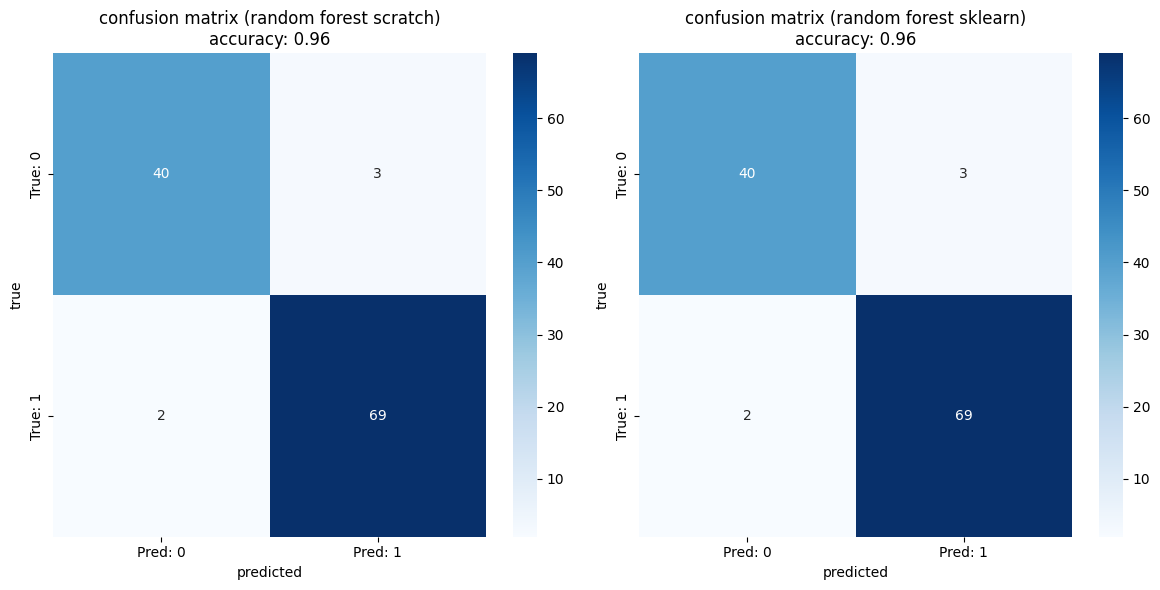

In [ ]:
# random forest from scratch
class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=None, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    class DecisionTreeScratch:
        def __init__(self, max_depth=None):
            self.max_depth = max_depth
            self.tree = None

        def _gini(self, y):
            classes = np.unique(y)
            gini = 1.0
            for c in classes:
                p = np.sum(y == c) / len(y)
                gini -= p ** 2
            return gini

        def _split(self, X, y, feature_index, threshold):
            left_mask = X[:, feature_index] <= threshold
            right_mask = ~left_mask
            return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

        def _best_split(self, X, y):
            best_gini = float('inf')
            best_feature = None
            best_threshold = None
            for feature_index in range(X.shape[1]):
                thresholds = np.unique(X[:, feature_index])
                for threshold in thresholds:
                    X_left, X_right, y_left, y_right = self._split(X, y, feature_index, threshold)
                    if len(y_left) == 0 or len(y_right) == 0:
                        continue
                    gini_left = self._gini(y_left)
                    gini_right = self._gini(y_right)
                    gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
                    if gini < best_gini:
                        best_gini = gini
                        best_feature = feature_index
                        best_threshold = threshold
            return best_feature, best_threshold

        def _build_tree(self, X, y, depth):
            num_samples, num_features = X.shape
            num_labels = len(np.unique(y))

            if depth >= self.max_depth or num_labels == 1 or num_samples == 0:
                leaf_value = self._most_common_label(y)
                return {"leaf": leaf_value}

            feature_index, threshold = self._best_split(X, y)
            if feature_index is None:
                leaf_value = self._most_common_label(y)
                return {"leaf": leaf_value}

            X_left, X_right, y_left, y_right = self._split(X, y, feature_index, threshold)
            left_subtree = self._build_tree(X_left, y_left, depth + 1)
            right_subtree = self._build_tree(X_right, y_right, depth + 1)
            return {"feature_index": feature_index, "threshold": threshold, "left": left_subtree, "right": right_subtree}

        def _most_common_label(self, y):
            return np.bincount(y).argmax()

        def fit(self, X, y):
            self.tree = self._build_tree(X, y, 0)

        def _traverse_tree(self, x, tree):
            if "leaf" in tree:
                return tree["leaf"]
            feature_index = tree["feature_index"]
            threshold = tree["threshold"]
            if x[feature_index] <= threshold:
                return self._traverse_tree(x, tree["left"])
            return self._traverse_tree(x, tree["right"])

        def predict(self, X):
            return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _subsample_features(self, X):
        n_features = X.shape[1]
        max_features = int(np.sqrt(n_features)) if self.max_features == 'sqrt' else n_features
        feature_indices = np.random.choice(n_features, max_features, replace=False)
        return feature_indices

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = self.DecisionTreeScratch(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)
        return majority_votes

# load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest from scratch
rf_scratch = RandomForestScratch(n_estimators=10, max_depth=5)
rf_scratch.fit(X_train, y_train)
y_pred_scratch = rf_scratch.predict(X_test)

# train random forest using sklearn
rf_sklearn = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
rf_sklearn.fit(X_train, y_train)
y_pred_sklearn = rf_sklearn.predict(X_test)

# evaluate models
cm_scratch = confusion_matrix(y_test, y_pred_scratch)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

# plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'], ax=axs[0])
axs[0].set_title(f'confusion matrix (random forest scratch)\naccuracy: {accuracy_scratch:.2f}')
axs[0].set_xlabel('predicted')
axs[0].set_ylabel('true')

sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'], ax=axs[1])
axs[1].set_title(f'confusion matrix (random forest sklearn)\naccuracy: {accuracy_sklearn:.2f}')
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('true')

plt.tight_layout()
plt.show()